# E-11. Pneumonia_Diagnosis


## 1. 패키지 import

In [68]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [92]:
# 변수 생성하기

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [93]:
# 나눠져있는 데이터 개수 확인하기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))
# 89%, 10.7%, 0.3%
# val 개수가 상대적으로 적은 것을 확인

5216
624
16


In [94]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8) # 실수 입력 시 내림하여 정수 반환
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [95]:
# 정상 이미지와 폐렴 이미지 구분이 필요
# 파일 경로를 통해 확인해보기
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1388_bacteria_3529.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person614_bacteria_2483.jpeg


In [96]:
# 파일 경로에 Normal이 있는지 확인하여 정상 이미지의 수를 센다
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 pneuumonia가 있는지 확인하여 폐렴 이미지의 수를 센다
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1075
Pneumonia images count in training set: 3110


In [97]:
# 페렴 이미지 수가 3배 더 많음
# CNN은 데이터가 클래스별 balance가 좋을수록 training을 잘한다.

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [98]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [99]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
# 파일 경로를 이용하여 라벨 데이터를 만들어주는 함수 생성
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [100]:
# 이미지를 알맞은 형식으로 바꿉니다.
# 이미지사이즈 통일
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [101]:
# train 데이터 셋과 validation 데이터 셋을 만들기
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [102]:
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용
# train_ds.take(1): 1개의 이미지만 가져오겠다는 의미
# 
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [103]:
# test 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [104]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    #shuffle(): 고정크기 버퍼 유지, 해당 버퍼에 무작위로 균일하게 다음 요소 선택
    ds = ds.repeat() 
    # repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줌
    ds = ds.batch(BATCH_SIZE)
    # BATCH_SIZE에서 정한 만큼의 배치로 주어짐
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    #  학습 데이터를 나눠서 읽어옴 - 리소스 유휴 상태를 줄임
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

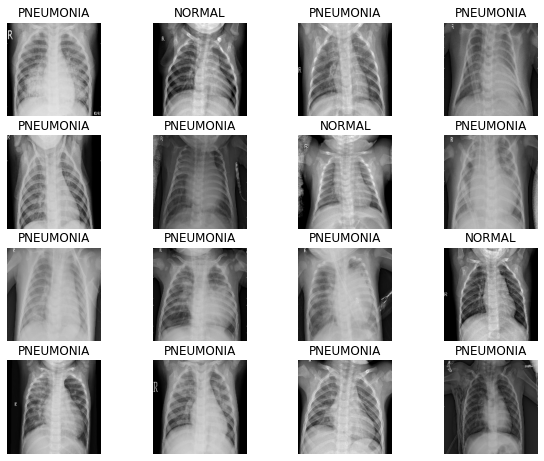

In [105]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. 모델링

In [106]:
# Convolution을 두 번 진행
#  Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
#  Max Pooling
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [61]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### batchnormalization만

In [112]:
def dense_block2(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),   
    ])
    return block

In [113]:
def build_model2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block2(512),
        dense_block2(128),
        dense_block2(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### Dropout만

In [122]:
def dense_block3(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [123]:
def build_model3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [124]:
# Weight balancing: training set의 각 데이터에서 loss를 계산할 때 
# 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# 'Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
#  'Pneumonia' 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 5. 모델 훈련

In [87]:
with tf.device('/GPU:0'): # GPU 사용
    model = build_model() 

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 87s 234ms/step - loss: 0.5425 - accuracy: 0.7204 - precision: 0.9023 - recall: 0.6961 - val_loss: 0.6035 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 224ms/step - loss: 0.2502 - accuracy: 0.9069 - precision: 0.9745 - recall: 0.8989 - val_loss: 1.0267 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 58s 224ms/step - loss: 0.2174 - accuracy: 0.9206 - precision: 0.9727 - recall: 0.9188 - val_loss: 0.3736 - val_accuracy: 0.8260 - val_precision: 0.8087 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 59s 227ms/step - loss: 0.1643 - accuracy: 0.9409 - precision: 0.9841 - recall: 0.9358 - val_loss: 0.0893 - val_accuracy: 0.9683 - val_precision: 0.9680 - val_recall: 0.9895
Epoch 5/25
261/261 [==============================] - 59s 228ms/step - loss: 0.1750 - accura

## 6. 결과 확인 및 시각화

BATCH_SIZE = 16, EPOCHS = 25, BatchNormalization, Dropout

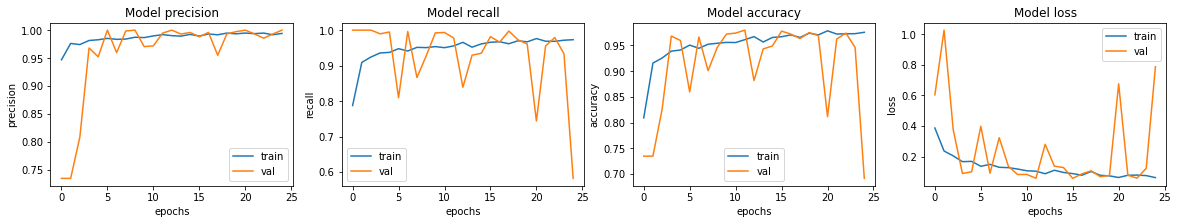

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 138ms/step - loss: 0.5725 - accuracy: 0.7901 - precision: 0.9360 - recall: 0.7128
Loss: 0.57246333360672,
Accuracy: 0.7900640964508057,
Precision: 0.936026930809021,
Recall: 0.7128205299377441


## 7. 성능 향상 시키기

### 1차 시도
BATCH_SIZE = 16, EPOCHS = 20, BatchNormalization, Dropout

In [45]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 70s 233ms/step - loss: 0.1898 - accuracy: 0.9253 - precision: 0.9794 - recall: 0.9189 - val_loss: 0.1399 - val_accuracy: 0.9423 - val_precision: 0.9301 - val_recall: 0.9961
Epoch 2/20
261/261 [==============================] - 58s 224ms/step - loss: 0.1602 - accuracy: 0.9382 - precision: 0.9814 - recall: 0.9347 - val_loss: 7.4073 - val_accuracy: 0.2702 - val_precision: 1.0000 - val_recall: 0.0052
Epoch 3/20
261/261 [==============================] - 58s 224ms/step - loss: 0.1717 - accuracy: 0.9308 - precision: 0.9815 - recall: 0.9243 - val_loss: 0.0958 - val_accuracy: 0.9644 - val_precision: 0.9677 - val_recall: 0.9842
Epoch 4/20
261/261 [==============================] - 59s 225ms/step - loss: 0.1504 - accuracy: 0.9452 - precision: 0.9848 - recall: 0.9407 - val_loss: 0.2058 - val_accuracy: 0.9135 - val_precision: 0.8954 - val_recall: 0.9987
Epoch 5/20
261/261 [==============================] - 61s 235ms/step - loss: 0.1566 - accura

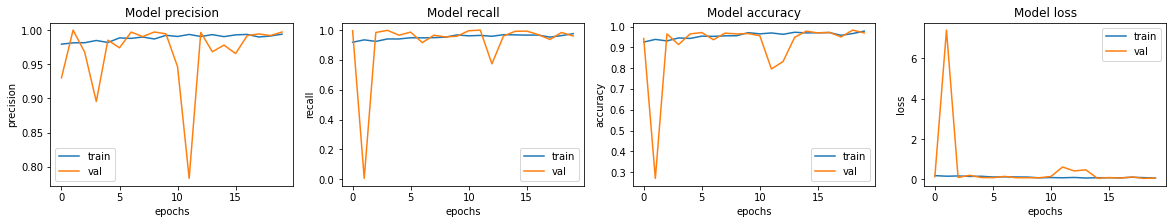

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [47]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 142ms/step - loss: 0.7861 - accuracy: 0.8237 - precision: 0.7846 - recall: 0.9897
Loss: 0.7860612869262695,
Accuracy: 0.8237179517745972,
Precision: 0.7845528721809387,
Recall: 0.9897435903549194


### 2차 시도 
BATCH_SIZE = 16, EPOCHS = 15, BatchNormalization, Dropout

In [21]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
261/261 [==============================] - 86s 234ms/step - loss: 0.5552 - accuracy: 0.7154 - precision: 0.9083 - recall: 0.6869 - val_loss: 0.7256 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 58s 222ms/step - loss: 0.2652 - accuracy: 0.8913 - precision: 0.9671 - recall: 0.8841 - val_loss: 1.4146 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 58s 223ms/step - loss: 0.1737 - accuracy: 0.9308 - precision: 0.9780 - recall: 0.9284 - val_loss: 0.1586 - val_accuracy: 0.9317 - val_precision: 0.9179 - val_recall: 0.9961
Epoch 4/15
261/261 [==============================] - 59s 226ms/step - loss: 0.1915 - accuracy: 0.9336 - precision: 0.9777 - recall: 0.9315 - val_loss: 0.0945 - val_accuracy: 0.9663 - val_precision: 0.9620 - val_recall: 0.9935
Epoch 5/15
261/261 [==============================] - 59s 227ms/step - loss: 0.1651 - accura

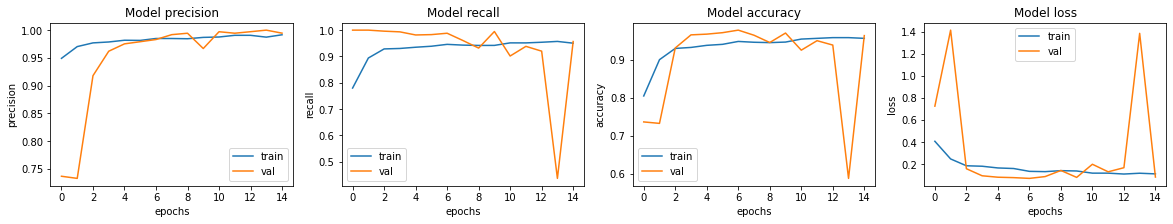

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 145ms/step - loss: 0.6375 - accuracy: 0.8478 - precision: 0.8132 - recall: 0.9821
Loss: 0.6374834775924683,
Accuracy: 0.8477563858032227,
Precision: 0.8131634593009949,
Recall: 0.9820512533187866


### 3차 시도 
BATCH_SIZE = 16, EPOCHS = 10, BatchNormalization, Dropout

In [43]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 70s 226ms/step - loss: 0.5294 - accuracy: 0.7107 - precision: 0.9176 - recall: 0.6752 - val_loss: 0.6485 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 58s 221ms/step - loss: 0.2444 - accuracy: 0.9037 - precision: 0.9693 - recall: 0.8993 - val_loss: 1.5666 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 58s 223ms/step - loss: 0.2044 - accuracy: 0.9255 - precision: 0.9751 - recall: 0.9235 - val_loss: 0.1209 - val_accuracy: 0.9635 - val_precision: 0.9905 - val_recall: 0.9594
Epoch 4/10
261/261 [==============================] - 60s 230ms/step - loss: 0.2025 - accuracy: 0.9239 - precision: 0.9725 - recall: 0.9241 - val_loss: 0.0828 - val_accuracy: 0.9750 - val_precision: 0.9843 - val_recall: 0.9817
Epoch 5/10
261/261 [==============================] - 61s 233ms/step - loss: 0.1613 - accura

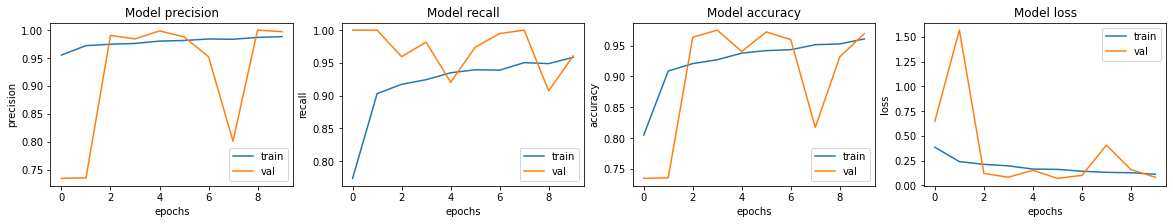

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 147ms/step - loss: 0.4964 - accuracy: 0.8526 - precision: 0.8170 - recall: 0.9846
Loss: 0.49639421701431274,
Accuracy: 0.8525640964508057,
Precision: 0.8170212507247925,
Recall: 0.9846153855323792


### 4차 시도 
BATCH_SIZE = 32, EPOCHS = 10, BatchNormalization, Dropout

In [65]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 105s 448ms/step - loss: 0.6037 - accuracy: 0.6736 - precision: 0.9040 - recall: 0.6223 - val_loss: 0.5944 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 56s 434ms/step - loss: 0.2329 - accuracy: 0.9068 - precision: 0.9843 - recall: 0.8894 - val_loss: 0.8288 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 57s 438ms/step - loss: 0.1654 - accuracy: 0.9397 - precision: 0.9861 - recall: 0.9325 - val_loss: 0.9150 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 58s 448ms/step - loss: 0.1431 - accuracy: 0.9460 - precision: 0.9826 - recall: 0.9441 - val_loss: 0.9627 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 59s 455ms/step - loss: 0.1540 - accur

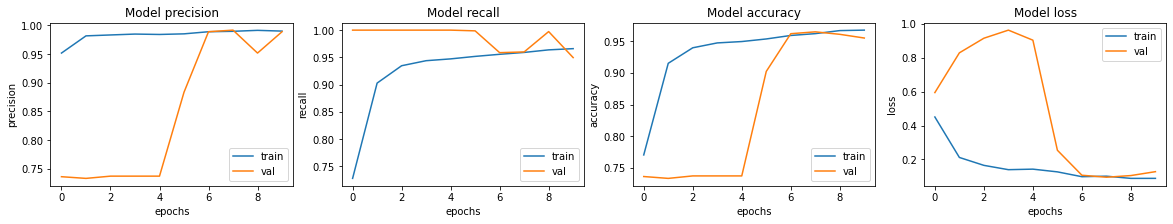

In [66]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [67]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 6s 271ms/step - loss: 0.5141 - accuracy: 0.8061 - precision: 0.7728 - recall: 0.9769
Loss: 0.5140796303749084,
Accuracy: 0.8060897588729858,
Precision: 0.772819459438324,
Recall: 0.9769230484962463


### 5차 시도 
BATCH_SIZE = 16, EPOCHS = 10, BatchNormalization

In [117]:
with tf.device('/GPU:0'): # GPU 사용
    model = build_model2() 

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [118]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 71s 226ms/step - loss: 0.3365 - accuracy: 0.8449 - precision: 0.9565 - recall: 0.8269 - val_loss: 0.6973 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 58s 221ms/step - loss: 0.1810 - accuracy: 0.9258 - precision: 0.9757 - recall: 0.9235 - val_loss: 1.3239 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 58s 222ms/step - loss: 0.1451 - accuracy: 0.9435 - precision: 0.9792 - recall: 0.9431 - val_loss: 0.0762 - val_accuracy: 0.9837 - val_precision: 0.9870 - val_recall: 0.9909
Epoch 4/10
261/261 [==============================] - 58s 222ms/step - loss: 0.1434 - accuracy: 0.9463 - precision: 0.9827 - recall: 0.9460 - val_loss: 0.0891 - val_accuracy: 0.9683 - val_precision: 0.9933 - val_recall: 0.9636
Epoch 5/10
261/261 [==============================] - 57s 220ms/step - loss: 0.1142 - accura

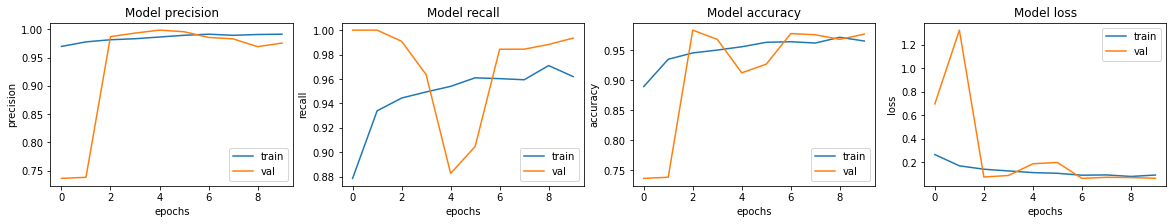

In [119]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [120]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 140ms/step - loss: 1.2508 - accuracy: 0.7067 - precision: 0.6832 - recall: 0.9897
Loss: 1.2507731914520264,
Accuracy: 0.7067307829856873,
Precision: 0.6831858158111572,
Recall: 0.9897435903549194


### 6차 시도 
BATCH_SIZE = 16, EPOCHS = 10, Dropout

In [125]:
with tf.device('/GPU:0'): # GPU 사용
    model = build_model3() 

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [126]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 70s 225ms/step - loss: 0.6188 - accuracy: 0.6911 - precision: 0.8862 - recall: 0.6658 - val_loss: 0.6971 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 57s 219ms/step - loss: 0.2555 - accuracy: 0.8986 - precision: 0.9716 - recall: 0.8891 - val_loss: 1.3625 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 57s 220ms/step - loss: 0.1993 - accuracy: 0.9215 - precision: 0.9786 - recall: 0.9145 - val_loss: 0.2519 - val_accuracy: 0.8971 - val_precision: 0.9970 - val_recall: 0.8633
Epoch 4/10
261/261 [==============================] - 58s 222ms/step - loss: 0.1874 - accuracy: 0.9258 - precision: 0.9811 - recall: 0.9180 - val_loss: 0.0839 - val_accuracy: 0.9683 - val_precision: 0.9730 - val_recall: 0.9844
Epoch 5/10
261/261 [==============================] - 59s 228ms/step - loss: 0.1945 - accura

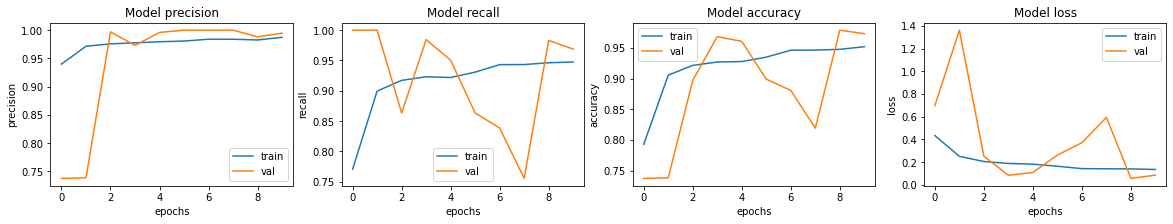

In [127]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [128]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 141ms/step - loss: 0.6479 - accuracy: 0.7804 - precision: 0.7476 - recall: 0.9795
Loss: 0.6478526592254639,
Accuracy: 0.7804487347602844,
Precision: 0.747553825378418,
Recall: 0.9794871807098389


## 결과 정리

- batchsize, epochs, batchnormalization, dropout 등을 변경하여 결과를 비교해보았다.
- 4번째 시도에서 accuuracy가 85% 에 도달하였다.
- batchnormalization, dropout을 모두 사용했을 때, 그리고 하나씩 사용했을 때의 결과 값을 비교해볼 수 있었다.


|No|설정값|정확도|
|:---:|:---:|:---:|
|01|BATCHSIZE=16, EPOCHS = 25(BatchNormalization, Dropout)|0.79|
|02|BATCHSIZE=16, EPOCHS = 20(BatchNormalization, Dropout)|0.82|
|03|BATCHSIZE=16, EPOCHS = 15(BatchNormalization, Dropout)|0.84|
|04|BATCHSIZE=16, EPOCHS = 10(BatchNormalization, Dropout)|0.85|
|05|BATCHSIZE=32, EPOCHS = 10(BatchNormalization, Dropout)|0.80|
|06|BATCHSIZE=16, EPOCHS = 10(BatchNormalization)|0.70|
|07|BATCHSIZE=16, EPOCHS = 10(Dropout)|0.78|



## 회고

- 좀 더 많이 시도해서 다양한 결과 값을 내고 싶었으나 시간이 없어서 그러지 못한 점이 아쉽다.

- 결론적으로 Accuracy 85%를 달성하였다.

- epoch 수만 줄였는데도 정확도가 눈에 띄게 오르는 것을 볼 수 있다. 

- batchnormalization, dropout을 하나씩 사용했을 때와 함께 사용했을 때의 차이가 궁금했는데 2개를 모두 사용했을 때의 결과가 더 좋은 것을 확인할 수 있었다.